# Implementing Batch Constrained Q-Learning
(https://arxiv.org/abs/1812.02900)
### References: 
OpenAI Gym <br/>
https://github.com/sfujim/BCQ

In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
import gym
import random
import pandas as pd
import importlib
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import torch.distributions as tdist
import torch.optim as opt
from collections import deque


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
import csv
import numpy as np
from scipy.optimize import minimize
import os


def price_signal(day = 45):

    """
    Utkarsha's work on price signal from a building with demand and solar

    Input: Day = an int signifying a 24 hour period. 365 total, all of 2012, start at 1.
    Output: netdemand_price, a measure of how expensive energy is at each time in the day
        optionally, we can return the optimized demand, which is the building
        calculating where the net demand should be allocated
    """

    pv = np.array([])
    price = np.array([])
    demand = np.array([])
    baselines_path = os.path.split(os.getcwd())[0]
    data_path = os.path.join(baselines_path, "behavioral_sim", "building_data.csv")
    with open(data_path, encoding='utf8') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        next(csvreader,None)
        rowcount = 0
        for row in csvreader:
            pv = np.append(pv, 0.001*float(row[3])) # Converting Wh to kWh
            price = np.append(price, float(row[2])) # Cost per kWh
            val = row[5]
            if val in (None,""): #How to treat missing values
                val = 0
            else:
                val = float(val) # kWh
            demand = np.append(demand, val)
            rowcount+=1
            # if rowcount>100:
            #     break

    pvsize = 5 #Assumption

    netdemand = demand.copy()
    for i in range(len(demand)):
        netdemand[i] = demand[i] - pvsize*pv[i]

    # Data starts at 5 am on Jan 1
    netdemand_24 = netdemand[24*day-5:24*day+19]
    price_24 = price[24*day-5:24*day+19]
    pv_24 = pv[24*day-5:24*day+19]
    demand_24 = demand[24*day-5:24*day+19]

    # Calculate optimal load scheduling. 90% of load is fixed, 10% is controllable.
    def optimise_24h(netdemand_24, price_24):
        currentcost = netdemand_24*price_24

        fixed_load = 0.9*netdemand_24
        controllable_load = sum(0.1*netdemand_24)
        # fixed_load = 0*netdemand_24
        # controllable_load = sum(netdemand_24)

        def objective(x):
            load = fixed_load + x
            cost = np.multiply(price_24,load)
            # Negative demand means zero cost, not negative cost
            # Adding L1 regularisation to penalise shifting of occupant demand
            lambd = 0.005
            return sum(np.maximum(cost,0)) + lambd*sum(abs(x-0.1*netdemand_24))

        def constraint_sumofx(x):
            return sum(x) - controllable_load

        def constraint_x_positive(x):
            return x

        x0 = np.zeros(24)
        cons = [
            {'type':'eq', 'fun': constraint_sumofx},
            {'type':'ineq', 'fun':constraint_x_positive}
        ]
        sol = minimize(objective, x0, constraints=cons)
        return sol

    sol = optimise_24h(netdemand_24,price_24)
    x = sol['x']

    netdemand_price_24 = netdemand_24*price_24

    return(netdemand_price_24)

In [30]:
import cvxpy as cvx
import osqp
import numpy as np

#### file to calculate the rewards. Meant to be modular: 
#### class Rewards should have several different functions by Dec 2019


class Reward():
    def __init__(self, energy_use, prices, min_demand, max_demand):
        """
        Args: 
            energy_use: list returned by Person class signifying energy use 
            prices: list returned by grid signifying cost throughout day 
            min_demand: value computed by Person class signifying minimum energy use long term
            max_demand: value computed by Person class signifying maximum energy use long term
        """

        self.energy_use = np.array(energy_use)
        self.prices = np.array(prices) 
        self._num_timesteps = energy_use.shape[0]
        self.min_demand = min_demand
        self.max_demand = max_demand
        self.total_demand = np.sum(energy_use)

    def ideal_use_calculation(self):
        """
        Computes an optimization of demand according to price 

        returns: np.array of ideal energy demands given a price signal 
        """

        demands = cvx.Variable(self._num_timesteps)
        min_demand = cvx.Parameter()
        max_demand = cvx.Parameter()
        total_demand = cvx.Parameter()
        prices = cvx.Parameter(self._num_timesteps)

        min_demand = self.min_demand
        max_demand = self.max_demand
        total_demand = self.total_demand
        prices = self.prices
        constraints = [cvx.sum(demands, axis=0, keepdims=True) == total_demand]
        # constraints = [np.ones(self._num_timesteps).T * demands == total_demand]
        for i in range(self._num_timesteps):
            constraints += [demands[i] <= max_demand]
            constraints += [min_demand <= demands[i]]	


        objective = cvx.Minimize(demands.T * prices)
        problem = cvx.Problem(objective, constraints)

        problem.solve(solver = cvx.OSQP, verbose=False)
        return np.array(demands.value)

    def neg_distance_from_ideal(self, demands):
        """
        args: 
            demands: np.array() of demands from ideal_use_calculation()

        returns: 
            a numerical distance metric, negated
        """

        return -((demands - self.energy_use)**2).sum()

    def cost_distance(self, ideal_demands):
        """
        args: 
            demands: np.array() of demands from ideal_use_calculation()

        returns: 
            a cost-based distance metric, negated
        """
        current_cost = np.dot(self.prices, self.energy_use)
        ideal_cost = np.dot(self.prices, ideal_demands)

        cost_difference = ideal_cost - current_cost

        return cost_difference

    def log_cost_distance(self, ideal_demands):
        """
        args: 
            demands: np.array() of demands from ideal_use_calculation()

        returns: 
            the log of the cost distance
        """
        current_cost = np.dot(self.prices, self.energy_use)
        ideal_cost = np.dot(self.prices, ideal_demands)

        cost_difference = ideal_cost - current_cost

        #TODO ENSURE THAT COST DIFFERENCE IS < 0
        if cost_difference < 0: 
            return -np.log(-cost_difference)
        else:
            print("WEIRD REWARD ALERT. IDEAL COST >= CURRENT COST. returning reward of 10")
            return 10

    def scaled_cost_distance(self, ideal_demands):
        """
        args: 
            demands: np.array() of demands from ideal_use_calculation()

        returns: 
            a cost-based distance metric normalized by total ideal cost
        """
        current_cost = np.dot(self.prices, self.energy_use)
        ideal_cost = np.dot(self.prices, ideal_demands)

        cost_difference = ideal_cost - current_cost

        return cost_difference/ideal_cost


In [31]:
import pandas as pd
import numpy as np

#### file to make the simulation of people that we can work with 


class Person():
    """ Person (parent?) class -- will define how the person takes in a points signal and puts out an energy signal 
    baseline_energy = a list or dataframe of values. This is data from SinBerBEST 
    points_multiplier = an int which describes how sensitive each person is to points 

    """

    def __init__(self, baseline_energy_df, points_multiplier = 1):
        self.baseline_energy_df = baseline_energy_df
        self.baseline_energy = np.array(self.baseline_energy_df["net_energy_use"])
        self.points_multiplier = points_multiplier

        baseline_min = self.baseline_energy.min()
        baseline_max = self.baseline_energy.max()
        baseline_range = baseline_max - baseline_min

        self.min_demand = np.maximum(0, baseline_min + baseline_range * .05)
        self.max_demand = np.maximum(0, baseline_min + baseline_range * .95)


    def energy_output_simple_linear(self, points):
        """Determines the energy output of the person, based on the formula:

        y[n] = -sum_{rolling window of 5} points + baseline_energy + noise

        inputs: points - list or dataframe of points values. Assumes that the 
        list will be in the same time increment that energy_output will be. 

        For now, that's in 1 hour increments

        """
        points_df = pd.DataFrame(points)

        points_effect = (
            points_df
                .rolling(
                        window = 5,
                        min_periods = 1)
                .mean()
            )



        time = points_effect.shape[0]
        energy_output= []

        for t in range(time):
            temp_energy = self.baseline_energy[t] - points_effect.iloc[t]*self.points_multiplier + \
                np.random.normal(1)
            energy_output.append(temp_energy)

        return pd.DataFrame(energy_output)

    def pure_linear_signal(self, points, baseline_day=0):
        """
        A linear person. The more points you give them, the less energy they will use
        (within some bounds) for each hour. No rolling effects or anything. The simplest
        signal. 
        """

        # hack here to always grab the first day from the baseline_energy
        output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]

        points_effect = np.array(points * self.points_multiplier)
        output = output - points_effect

        # impose bounds/constraints
        output = np.maximum(output, self.min_demand)
        output = np.minimum(output, self.max_demand)
        return output



    def get_min_demand(self):
        return self.min_demand
        # return np.quantile(self.baseline_energy, .05)

    def get_max_demand(self):
        return self.max_demand
        # return np.quantile(self.baseline_energy, .95)

class Person_with_hysteresis(Person):
    """ Wendy -- Determines the energy output of the person, based on the formula:

        y[n] = f(points) + baseline_energy + noise

        f: super special secret function that Wendy designs with hysteresis 

        inputs: points - list or dataframe of points values. Assumes that the 
        list will be in the same time increment that energy_output will be. 

        For now, that's in 5 minute increments"""

    def __init__(self, baseline_energy, points_multiplier = 1):
        pass


class FixedDemandPerson(Person):

    def __init__(self, baseline_energy_df, points_multiplier = 1):
        super().__init__(baseline_energy_df, points_multiplier)


    def demand_from_points(self, points, baseline_day=0):
        # hack here to always grab the first day from the baseline_energy
        output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
        total_demand = np.sum(output)


        points_effect = np.array(points * self.points_multiplier)
        output = output - points_effect

        # scale to keep total_demand (almost) constant
        # almost bc imposing bounds afterwards
        output = output * (total_demand/np.sum(output))

        # impose bounds/constraints
        output = np.maximum(output, self.min_demand)
        output = np.minimum(output, self.max_demand)

        return output

    def adverserial_linear(self, points, baseline_day=0):
        # hack here to always grab the first day from the baseline_energy
        output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
        total_demand = np.sum(output)


        points_effect = np.array(points * self.points_multiplier)
        output = output + points_effect

        # scale to keep total_demand (almost) constant
        # almost bc imposing bounds afterwards
        output = output * (total_demand/np.sum(output))

        # impose bounds/constraints
        output = np.maximum(output, self.min_demand)
        output = np.minimum(output, self.max_demand)

        return output

class DeterministicFunctionPerson(Person):

    def __init__(self, baseline_energy_df, points_multiplier = 1):
        super().__init__(baseline_energy_df, points_multiplier)

    def threshold_response_func(self, points):
        points = np.array(points) * self.points_multiplier
        threshold = np.mean(points)
        return [p if p>threshold else 0 for p in points]

    def exponential_response_func(self, points):
        points = np.array(points) * self.points_multiplier
        points_effect = [p**2 for p in points]

        return points_effect

    def sin_response_func(self,points):
        points = np.array(points) 
        # n = np.max(points)
        # points = [np.sin((float(i)/float(n))*np.pi) for i in points]	
        points = [np.sin(float(i)*np.pi)*self.points_multiplier for i in points]	
        points = points 
        return points

    def routine_output_transform(self, points_effect, baseline_day=0):
        output = np.array(self.baseline_energy)[baseline_day*24:baseline_day*24+10]
        total_demand = np.sum(output)

        # scale to keep total_demand (almost) constant
        # almost bc imposing bounds afterwards
        output = output - points_effect
        output = output * (total_demand/np.sum(output))

        # impose bounds/constraints
        output = np.maximum(output, self.min_demand)
        output = np.minimum(output, self.max_demand)
        return output

    def threshold_response(self, points):
        points_effect = self.threshold_response_func(points)
        output = self.routine_output_transform(points_effect)
        return output

    def sin_response(self, points):
        points_effect = self.sin_response_func(points)
        output = self.routine_output_transform(points_effect)
        return output

    def exp_response(self, points):
        points_effect = self.exponential_response_func(points)
        output = self.routine_output_transform(points_effect)
        return output

    def threshold_exp_response(self,points):
        points_effect = self.exponential_response_func(points)
        points_effect = self.threshold_response_func(points_effect)
        output = self.routine_output_transform(points_effect)
        return output

    def linear_response(self, points):
        points_effect = points*self.points_multiplier
        output = self.routine_output_transform(points_effect)
        return output





In [32]:
from gym import spaces
class BehavSimEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {'render.modes': ['human']}

    def __init__(self, one_day=False, energy_in_state=False):
        super(BehavSimEnv, self).__init__()

        discrete_space = [3] * 10
        self.action_space = spaces.MultiDiscrete(discrete_space)

        self.action_space = spaces.Box(low=0, high=10, shape=(10,), dtype=np.float32)
        if energy_in_state:
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(20,), dtype=np.float32)
        else:
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(10,), dtype=np.float32)

        self.one_day = one_day
        self.energy_in_state = energy_in_state
        self.prices = self._get_prices(one_day)
        assert self.prices.shape == (365, 10)

        self.player_dict = self._create_agents()
        self.cur_iter = 0
        self.day = 0
        print("BehavSimEnv Initialized")


    def _get_prices(self, one_day):
        
        all_prices = []
        if one_day:
            # if repeating the same day, then use a random day. 
            # SET FIXED DAY HERE
            day = 50
            price = price_signal(day + 1)
            price = np.array(price[8:18])
            for i in range(365):
                all_prices.append(price)
        else:
            day = 0
            for i in range(365):  
                price = price_signal(day + 1)
                price = np.array(price[8:18])
                # put a floor on the prices so we don't have negative prices
                price = np.maximum([0.01], price)
                all_prices.append(price)
                day += 1

        return np.array(all_prices)

    def _create_agents(self):
        """Initialize the market agents
            Args:
              None

            Return:
              agent_dict: dictionary of the agents
        """

        # TODO: This needs to be updated

        # Skipping rows b/c data is converted to PST, which is 16hours behind
        # so first 10 hours are actually 7/29 instead of 7/30
        
        # baseline_energy1 = convert_times(pd.read_csv("wg1.txt", sep = "\t", skiprows=range(1, 41)))
        # baseline_energy2 = convert_times(pd.read_csv("wg2.txt", sep = "\t", skiprows=range(1, 41)))
        # baseline_energy3 = convert_times(pd.read_csv("wg3.txt", sep = "\t", skiprows=range(1, 41)))

        # be1 = change_wg_to_diff(baseline_energy1)
        # be2 = change_wg_to_diff(baseline_energy2)
        # be3 = change_wg_to_diff(baseline_energy3)

        player_dict = {}

        # I dont trust the data at all
        # helper comment         [0, 1, 2, 3, 4, 5,  6,  7,  8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18, 19, 20,  21, 22, 23]
        sample_energy = np.array([0, 0, 0, 0, 0, 0, 20, 50, 80, 120, 200, 210, 180, 250, 380, 310, 220, 140, 100, 50, 20,  10,  0,  0])

        #only grab working hours (8am - 6pm)
        working_hour_energy = sample_energy[8:18]

        my_baseline_energy = pd.DataFrame(data={"net_energy_use": working_hour_energy})

        player_dict['player_0'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_1'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_2'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_3'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_4'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_5'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_6'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)
        player_dict['player_7'] = DeterministicFunctionPerson(my_baseline_energy, points_multiplier = 100)

        return player_dict

    def step(self, action):
        prev_observation = self.prices[self.day]
#         self.day = (self.day + 1) % 365
#         self.cur_iter += 1
        observation = prev_observation #self.cur#self.prices[self.day]
        done = True
#         if self.cur_iter > 0:
#             done = True
#         else:
#             done = False
        energy_consumptions = self._simulate_humans(prev_observation, action)
        #if self.energy_in_state:
            # HACK ALERT. USING AVG ENERGY CONSUMPTION FOR STATE SPACE. this will not work if people are not all the same
            #observation = np.concatenate(observation, energy_consumptions["avg"])
        reward = self._get_reward(prev_observation, energy_consumptions)
        info = {}
        return observation, reward, done, info

    def _simulate_humans(self, prev_observation, action):
        energy_consumptions = {}
        total_consumption = np.zeros(10)
        num_players = 0
        for player_name in self.player_dict:
            if player_name != "avg":
                player = self.player_dict[player_name]
                # get the points output from players
                # CHANGE PLAYER RESPONSE FN HERE
                player_energy = player.threshold_exp_response(action)
                energy_consumptions[player_name] = player_energy
                total_consumption += player_energy
                num_players += 1
        energy_consumptions["avg"] = total_consumption / num_players
        return energy_consumptions


    def _get_reward(self, prev_observation, energy_consumptions):
        total_reward = 0
        for player_name in energy_consumptions:
            if player_name != "avg":
                # get the points output from players
                player = self.player_dict[player_name]

                # get the reward from the player's output
                player_min_demand = player.get_min_demand()
                player_max_demand = player.get_max_demand()
                player_energy = energy_consumptions[player_name]
                player_reward = Reward(player_energy, prev_observation, player_min_demand, player_max_demand)
                player_ideal_demands = player_reward.ideal_use_calculation()
                # either distance from ideal or cost distance
                # distance = player_reward.neg_distance_from_ideal(player_ideal_demands)
                reward = player_reward.scaled_cost_distance(player_ideal_demands)

                total_reward += reward
        return total_reward
  
    def reset(self):
        self.day = np.random.randint(365)
        self.cur_iter = 0
        return self.prices[self.cur_iter]

    def render(self, mode='human'):
        pass

    def close (self):
        pass

In [36]:
class ReplayBuffer(object):
    def __init__(self):
        self.storage = []

    # Expects tuples of (state, next_state, action, reward, done)
    def add(self, data):
        self.storage.append(data)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        state, next_state, action, reward, done = [], [], [], [], []

        for i in ind: 
            s, s2, a, r, d = self.storage[i]
            state.append(np.array(s, copy=False))
            next_state.append(np.array(s2, copy=False))
            action.append(np.array(a, copy=False))
            reward.append(np.array(r, copy=False))
            done.append(np.array(d, copy=False))

        return (np.array(state), 
            np.array(next_state), 
            np.array(action), 
            np.array(reward).reshape(-1, 1), 
            np.array(done).reshape(-1, 1))

    def save(self, filename):
        np.save("./buffers/"+filename+".npy", self.storage)

    def load(self, filename):
        self.storage = np.load("./buffers/"+filename+".npy")

In [57]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, min_action, max_action):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, action_dim)
        self.max_action = max_action
        self.min_action = min_action


    def forward(self, state, action):
        a = F.relu(self.l1(torch.cat([state, action], 1)))
        a = F.relu(self.l2(a))
        a = 0.05 * self.max_action * torch.tanh(self.l3(a))
        return (a + action).clamp(self.min_action, self.max_action)


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim + action_dim, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

        self.l4 = nn.Linear(state_dim + action_dim, 400)
        self.l5 = nn.Linear(400, 300)
        self.l6 = nn.Linear(300, 1)


    def forward(self, state, action):
        q1 = F.relu(self.l1(torch.cat([state, action], 1)))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(torch.cat([state, action], 1)))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)
        return q1, q2


    def q1(self, state, action):
        q1 = F.relu(self.l1(torch.cat([state, action], 1)))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)
        return q1


# Vanilla Variational Auto-Encoder 
class VAE(nn.Module):
    def __init__(self, state_dim, action_dim, latent_dim, max_action):
        super(VAE, self).__init__()
        self.e1 = nn.Linear(state_dim + action_dim, 750)
        self.e2 = nn.Linear(750, 750)

        self.mean = nn.Linear(750, latent_dim)
        self.log_std = nn.Linear(750, latent_dim)

        self.d1 = nn.Linear(state_dim + latent_dim, 750)
        self.d2 = nn.Linear(750, 750)
        self.d3 = nn.Linear(750, action_dim)

        self.max_action = max_action
        self.latent_dim = latent_dim


    def forward(self, state, action):
        z = F.relu(self.e1(torch.cat([state, action], 1)))
        z = F.relu(self.e2(z))

        mean = self.mean(z)
        # Clamped for numerical stability 
        log_std = self.log_std(z).clamp(-4, 15)
        std = torch.exp(log_std)
        z = mean + std * torch.FloatTensor(np.random.normal(0, 1, size=(std.size()))).to(device) 

        u = self.decode(state, z)

        return u, mean, std


    def decode(self, state, z=None):
        # When sampling from the VAE, the latent vector is clipped to [-0.5, 0.5]
        if z is None:
            z = torch.FloatTensor(np.random.normal(0, 1, size=(state.size(0), self.latent_dim))).to(device).clamp(-0.5, 0.5)

        a = F.relu(self.d1(torch.cat([state, z], 1)))
        a = F.relu(self.d2(a))
        return self.max_action * torch.tanh(self.d3(a))



class BCQ(object):
    def __init__(self, state_dim, action_dim, min_action, max_action, replay_buffer):

        latent_dim = action_dim * 2

        self.actor = Actor(state_dim, action_dim, min_action, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, min_action, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())

        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())

        self.vae = VAE(state_dim, action_dim, latent_dim, max_action).to(device)
        self.vae_optimizer = torch.optim.Adam(self.vae.parameters()) 

        self.max_action = max_action
        self.min_action = min_action
        self.action_dim = action_dim
        
        self.replay_buffer = replay_buffer


    def select_action(self, state):		
        with torch.no_grad():
            state = torch.FloatTensor(state.reshape(1, -1)).repeat(10, 1).to(device)
            action = self.actor(state, self.vae.decode(state))
            q1 = self.critic.q1(state, action)
            ind = q1.max(0)[1]
        return action[ind].cpu().data.numpy().flatten()


    def train(self, iterations, batch_size=10, discount=0.99, tau=0.005):
        
        for it in range(iterations):
            print(str(it) + " / " + str(iterations))
            # Sample replay buffer / batch
            state_np, next_state_np, action, reward, done = self.replay_buffer.sample(batch_size)
            state 		= torch.FloatTensor(state_np).to(device)
            action 		= torch.FloatTensor(action).to(device)
            next_state 	= torch.FloatTensor(next_state_np).to(device)
            reward 		= torch.FloatTensor(reward).to(device)
            done 		= torch.FloatTensor(1 - done).to(device)


            # Variational Auto-Encoder Training
            recon, mean, std = self.vae(state, action)
            recon_loss = F.mse_loss(recon, action)
            KL_loss	= -0.5 * (1 + torch.log(std.pow(2)) - mean.pow(2) - std.pow(2)).mean()
            vae_loss = recon_loss + 0.5 * KL_loss

            self.vae_optimizer.zero_grad()
            vae_loss.backward()
            self.vae_optimizer.step()


            # Critic Training
            with torch.no_grad():

                # Duplicate state 10 times
                state_rep = torch.FloatTensor(np.repeat(next_state_np, 10, axis=0)).to(device)

                # Compute value of perturbed actions sampled from the VAE
                target_Q1, target_Q2 = self.critic_target(state_rep, self.actor_target(state_rep, self.vae.decode(state_rep)))

                # Soft Clipped Double Q-learning 
                target_Q = 0.75 * torch.min(target_Q1, target_Q2) + 0.25 * torch.max(target_Q1, target_Q2)
                target_Q = target_Q.view(batch_size, -1).max(1)[0].view(-1, 1)

                target_Q = reward + done * discount * target_Q

            current_Q1, current_Q2 = self.critic(state, action)
            critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()


            # Pertubation Model / Action Training
            sampled_actions = self.vae.decode(state)
            perturbed_actions = self.actor(state, sampled_actions)

            # Update through DPG
            actor_loss = -self.critic.q1(state, perturbed_actions).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()


            # Update Target Networks 
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [59]:
env = BehavSimEnv(True,False)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
replay_buffer = ReplayBuffer()
agent = BCQ(state_dim, action_dim,0,10,replay_buffer)
collect_data_steps = 3

state = env.prices[0]

for step in range(collect_data_steps):
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    replay_buffer.add((state,action,next_state,reward,done))
    state = next_state

rewards = []
action_star = []
max_iters = 30
for training_iterations in range(max_iters):
    print("=========================")
    print("Training Iteration " + str(training_iterations) + " out of " + str(max_iters))
    print("")
    agent.train(100)
    action = agent.select_action(state)
    next_state, reward, done, info = env.step(action)
    #replay_buffer.add((state,action,next_state,reward,done))
    rewards.append(reward)
    action_star = action
    print("=========================")


BehavSimEnv Initialized
Training Iteration 0 out of 30

0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
Training Iteration 1 out of 30

0 / 100
1 / 100
2 / 10

41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
Training Iteration 9 out of 30

0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 1

85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
Training Iteration 17 out of 30

0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 

21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
Training Iteration 26 out of 30

0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 

Text(0, 0.5, 'Reward')

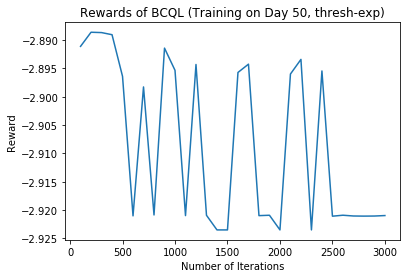

In [62]:
plt.plot([100*i for i in range(1,31)], rewards)
plt.title("Rewards of BCQL (Training on Day 50, thresh-exp)")
plt.xlabel("Number of Iterations")
plt.ylabel("Reward")

Text(0, 0.5, 'Price')

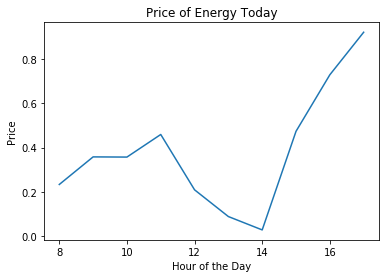

In [63]:
plt.plot([8,9,10,11,12,13,14,15,16,17],action_star)
plt.title("Price of Energy Today")
plt.xlabel("Hour of the Day")
plt.ylabel("Price")